In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100, 'display.max_columns', 200)
#строчка нужна, чтобы датасеты с множеством колонок отображались полностью
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Линейная регрессия: эксперимент на искусственных данных (4 балла)

Сгенерируем искусственные данные. Каждый объект имеет один признак, который записан в переменную $X$. Целевая переменная $y$ зависит от $X$ по закону $y = 7X - 10$. Поскольку восстанавливать в точности линейную зависимость не интересно, к целевой переменной добавлен шум, имеющий нормальное распределение. Ниже визуализировано распределение шума.

(array([1., 2., 1., 5., 2., 2., 1., 3., 1., 2.]),
 array([-12.16507925,  -9.36441451,  -6.56374977,  -3.76308502,
         -0.96242028,   1.83824446,   4.6389092 ,   7.43957394,
         10.24023868,  13.04090343,  15.84156817]),
 <a list of 10 Patch objects>)

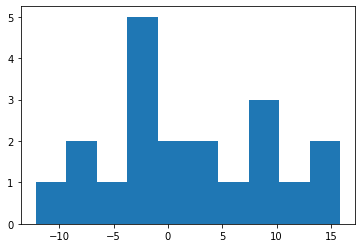

In [2]:
noise = np.random.randn(20) * 10
plt.hist(noise)

In [3]:
X = np.linspace(-5, 5, 20)
y = 10 * X - 7 + noise

X = X.reshape(-1,1) 
# Изменение формы необходимо, поскольку на вход линейной регрессии 
# должна подаваться двумерная матрица, а не вектор
X.shape

(20, 1)

### Задание 1 (0 баллов)
Разбейте данные на train и test в соотношении 1:1. Используйте функцию ``sklearn.model_selection.train_test_split``.

In [4]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.5)

Визуализируем данные, используя библиотеку matplotlib.

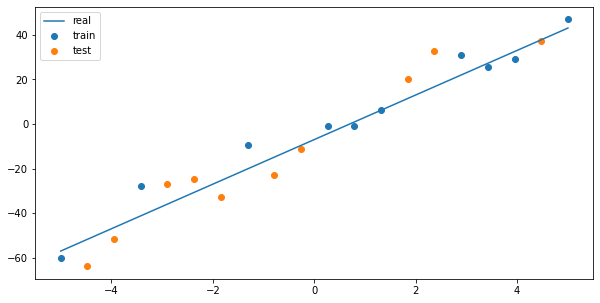

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(X, 10 * X - 7, label='real')
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()
plt.show()

### Задание 2 (2 балла)
Обучите модель линейной регрессии на тренировочной выборке и предскажите значения на тестовой.
Предсказанные ответы сохраните в переменную ``predictions``, а веса модели (угол наклона прямой и свободный член) --- в переменные ``w``, ``b``. О том, где внутри модели сохраняются веса, можно прочесть в <a href=https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html>документации</a>.

In [8]:
from sklearn.linear_model import LinearRegression

In [18]:
model = LinearRegression()
model.fit(X_train,y_train)
# scope
w = model.coef_
# intercept
b = model.intercept_

In [19]:
w, b

(array([9.53958313]), -3.609325879080231)

Визуализируем предсказания.

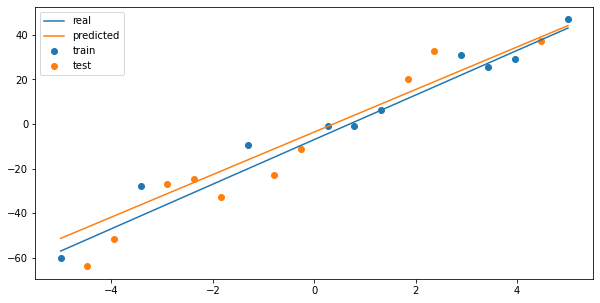

In [26]:
# Рисуем холст 
plt.figure(figsize=(10, 5))
# Рисуем прямую регрессии
plt.plot(X, 10 * X - 7, label='real')
# Рисуем разброс тренировочных данных
plt.scatter(X_train, y_train, label='train')
# Рисуем разборос тестовых данных
plt.scatter(X_test, y_test, label='test')
# Рисуем линию предсказываемой регрессии
plt.plot(X, X * w + b, label='predicted')
# Отображаем легенду на графике
plt.legend()
plt.show()

### Задание 3 (1 балл)
Вычислите среднеквадратичную и среднюю абсолютную ошибку на обучающем и тестовом множествах.

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)




In [33]:
# MSE
print('Train MSE: ', mean_squared_error(y_train,y_train_predicted))
print('Test MSE: ', mean_squared_error(y_test,y_test_predicted))

Train MSE:  31.49743741946235
Test MSE:  95.58894793294283


In [34]:
# MAE
print('Train MAE: ', mean_absolute_error(y_train,y_train_predicted))
print('Test MAE: ', mean_absolute_error(y_test,y_test_predicted))

Train MAE:  4.9912150760176655
Test MAE:  8.318263297010972


### Задание 4 (1 балл)
Сделайте выводы. Верно ли, что ошибка на train меньше, чем на test? В связи с чем это происходит?

Такая разница в результатах обусловлена тем что алгоритм подстроился под тренировочную выборку, он нашел на этой выборке какие то сложные взаимосвязи, присущие только ей. И когда алгоритм получил для обработки новые данные в виде тестовой выборки, то не смог должным образом обработать ее.

# Предсказание отклика на маркетинговую кампанию банка с помощью логистической регрессии (6 баллов)

В этом разделе вы решите задачу предсказания отклика на маркетинговую кампанию с помощью логистической регрессии. 

## Постановка задачи
Для нового продукта банка необходимо определить круг клиентов, которым будет совершён телефонный звонок с предложением продукта. Известно, что один звонок независимо от результата стоит 10 рублей, а каждый успешный звонок приносит банку 100 рублей. Цель -- максимизировать прибыль банка. 

Мы имеем задачу классификации клиентов на два класса. Для каждого клиента будем предсказывать вероятность отклика на кампанию, а затем выберем пороговую вероятность обзвона. Предсказывать вероятность предлагается с помощью логистической регрессии.

## Сбор данных
В вашем распоряжении есть выборка из предыдущих звонков, для каждого из которых имеется вектор признаков (характеристики клиента и продукта), а также результат звонка. Загрузим данные с помощью библиотеки Pandas. Создадим объект ``data`` класса ``pandas.DataFrame``.

Описание данных: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [40]:
data = pd.read_csv('data/bank-additional-full.csv', sep=';')
# Если строчка не выполняется, ноутбук нужно сохранить на 
# компьютере и данные положить в ту же папку

Взглянем на выборку, соберём предварительную информацию о ней, изучим признаки с помощью функций ``head``, ``info``, ``describe`` библиотеки Pandas.

In [41]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [43]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Задание 5 (1 балл)
Сейчас целевая переменная записана в ``data['y']`` и имеет текстовый вид ("yes" или "no"). Переведите её в числовой вид. Вам поможет класс ``LabelBinarizer`` модуля ``sklearn.preproccesing``. Модуль содержит классы для предобработки признаков.

Выделите целевое значение в переменную ``y``.

In [48]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()

y = binarizer.fit_transform(data['y'])

data['y'] = y
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [49]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

Видим, что классы очень несбалансированы. 

## Предварительный анализ признаков
В датасете есть признак ``duration``, обозначающий длительность совершённого звонка. Это значение неизвестно до совершения звонка, поэтому не может быть использовано для предсказания. Удалим эту переменную из рассмотрения. Сделаем это с помощью метода ``drop`` класса ``pandas.DataFrame``.

In [50]:
data = data.drop(columns=['duration'])

В датасете многие признаки являются категориальными. Мы ограничимся их one-hot кодированием. 

## One-hot кодирование
One-hot кодирование категориального признака ``feature``, принимающего $k$ значений ``1``, ``2``, ``3``, $\ldots$, ``t``, заключается в создании $t$ новых бинарных признаков ``"feature == 1"``, ``"feature == 2"``, $\ldots$, ``"feature == t"``, определяющихся по формуле

$$\text{"feature == i"} = 
\begin{cases}
1,& feature = i\\
0,& feature \neq i
\end{cases}.$$


### Задание 6 (1 балл)
Закодируйте категориальные признаки. One-hot encoding с помощью Pandas можно выполнить с помощью функции ``get_dummies``. 


In [ ]:
# Разделим признаки на числовые и категориальные с помощью функции ``select_dtypes``
# Отбор только категориальных признаков
data_categorical = data.select_dtypes(include=['object'])
#Отбор только количественных признаков
data_numeric = data.select_dtypes(exclude=['object'])



In [53]:
# one_hot
data_one_hot = pd.get_dummies(data_categorical)
data_one_hot

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


### Визуализация данных
Визуализация данных полезна для предварительного анализа. Подробно о визуализации мы поговорим на следующих занятиях, а сейчас ограничимся построением матрицы корреляций по числовым признакам. Нам пригодится функция ``heatmap`` библиотеки Seaborn, а также функция ``corr`` класса ``pandas.DataFrame``.

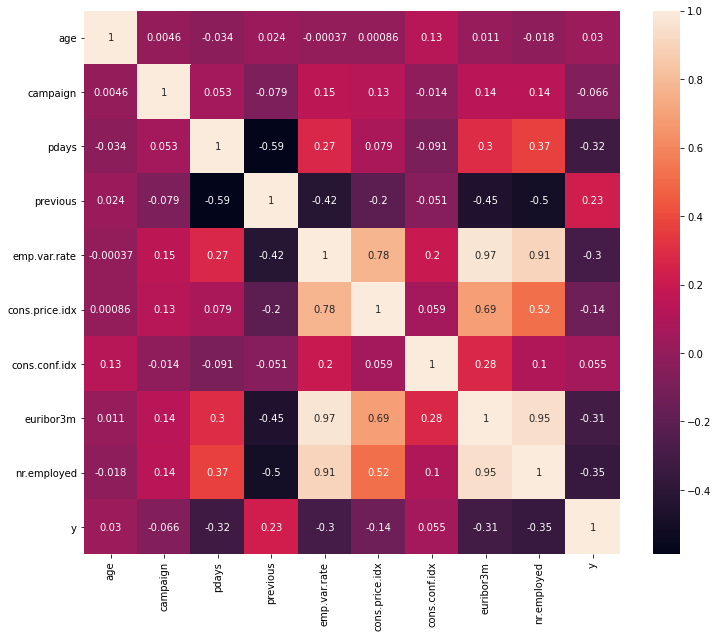

In [55]:
plt.figure(figsize=(12,10))
# параметр annot для отображения числового значения корреляции
sns.heatmap(data_numeric.corr(),annot=True)

Как видно некоторые признаки имеют очень вы высокую корреляцию 0.95,0.97. По идее, их надо было бы удалить.

## Составление плана обучения и тестирования, train и test

Прежде чем производить обработку признаков, необходимо составить план обучения и тестирования. Чтобы смоделировать "реальную" производственную ситуацию и избежать переобучения, необходимо разделить данные на train и test. Выборка test **будет недоступна** на стадии обработки признаков и обучения. Строго говоря, выделение категориальных признаков также необхоимо было проводить после разбиения, но для простоты мы опустим этот момент. Также не забудем выбросить целевую переменную из ``data_numeric``.

Разобьём данные на train и test в соотношении 70:30 с помощью функции ``train_test_split`` модуля ``sklearn.model_selection``.

In [56]:
data_numeric = data_numeric.drop(columns=['y'])

from sklearn.model_selection import train_test_split
# Надо посмотреть документацию по train_test_split 
data_train, data_test, data_categorical_train, data_categorical_test,\
data_one_hot_train, data_one_hot_test,\
data_numeric_train, data_numeric_test, y_train, y_test\
= train_test_split(data, data_categorical, data_one_hot, data_numeric, y)

### Обработка числовых признаков, нормировка
Есть множество методов обработки, генерации новых признаков, отбора признаков и т.д. Многие из них реализованы в модулях ``sklearn.preprocessing`` и ``sklearn.feature_selection``. Сейчас мы ограничимся нормировкой признаков. 

Нормировка признаков производится по формуле 
$$x \rightarrow \frac{x - a}{\sigma},$$
где $a$ -- среднее значение признака, а $\sigma$ -- среднее квадратическое отклонение признака, вычисляемое по формуле $$\sigma = \sqrt{\frac{(x_1 - a)^2 + \ldots + (x_n - a)^2}{n}}.$$



### Задание 7 (1 балл)
Произведите нормировку обучающих данных. Вам поможет класс ``StandartScaler`` модуля ``sklearn.preprocessing``. Нужно быть осторожным: StandartScaler выводит нас за рамки pandas. Результат применения -- ``numpy.ndarray``.

Необходимо нормировать только числовые данные: data_numeric_train.

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_numeric_train)
data_normalized_train=scaler.fit_transform(data_numeric_train)
data_normalized_train.mean(),data_normalized_train.std()


(1.0083905841741217e-15, 1.0)

## Формирование матрицы объекты-признаки
После выполнения всех предыдущих действий мы наконец готовы сформировать матрицу объекты-признаки из всех данных, которые нам доступны. Сольём категориальные и числовые признаки, сформировав тренировочную матрицу объекты-признаки.

In [72]:
X_train = np.concatenate([data_normalized_train, data_one_hot_train], axis=1)

In [73]:
X_train.shape

(30891, 62)

(10297, 62)

## Обучение алгоритма

### Задание 8 (1 балл)
Создайте и обучите логистическую регрессию. Нужный вам класс ``LogisticRegression`` находится в модуле ``sklearn.linear_model``.
Предскажите вероятности принадлежности объектов обучающей выборки к классу 1. Используйте метод модели ``predict_proba``.

In [78]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train,y_train)
y_train_predicted_probs = model.predict_proba(X_train)

## Тестирование модели

После обучения модели необходимо протестировать её и посчитать необходимые метрики. Для этого вспомним про тестовую выборку. 
### Задание 9 (1 балл)
Примените к тестовой выборке те же преобразования, что и к обучающей. В нашем случае это нормировка, конкатенация и предсказание вероятностей. Обратите внимание, что параметры нормировки сохранены в объекте ``scaler``.

In [ ]:
# К слову, нам нужно провести ту же операцию и с тестовой матрицей обьектов-признаков
scaler_test = StandardScaler()
scaler_test.fit(data_numeric_test)
data_normalized_test = scaler_test.fit_transform(data_numeric_test)
# Формирование тестовой выборки
X_test = np.concatenate([data_normalized_test,data_one_hot_test],axis=1)
X_test.shape

In [0]:
data_normalized_test = <YOUR CODE>
X_test = <YOUR CODE>

y_test_predicted_probs = <YOUR CODE>

Теперь, когда мы нашли вероятности отклика, можем выбрать порог вероятности обзвона (скажем, 0.5). Построим для обучающей и тестовой выборок ROC-кривые и посчитаем значения метрик. Нам поможет модуль ``sklearn.metrics`` и его функции ``accuracy_score``, ``precision_score``, ``recall_score``, ``roc_auc_score``, ``roc_curve``. 
Напишем функцию для вычисления метрик и построения графиков.

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

def print_metrics(y_true, y_predicted_probs, threshold_probability = 0.5, names = ['train', 'test']):
    plt.figure(figsize=(10,6))
    for y_true_, y_predicted_probs_, name in zip(y_true, y_predicted_probs, names):
        plt.plot(*(roc_curve(y_true_, y_predicted_probs_)[0:2]), label=name + ' ROC-curve')
        print(name + ' accuracy: ', accuracy_score(y_true_, y_predicted_probs_ > threshold_probability))
        print(name + ' precision: ', precision_score(y_true_, y_predicted_probs_ > threshold_probability))
        print(name + ' recall: ', recall_score(y_true_, y_predicted_probs_ > threshold_probability))
        print(name + ' ROC-AUC: ', roc_auc_score(y_true_, y_predicted_probs_))
    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.grid(True)
    plt.legend()
    plt.show()

In [0]:
print_metrics([y_train, y_test], [y_train_predicted_probs, y_test_predicted_probs],
              0.5, names = ['train', 'test'])

## Бонусное задание: интерпретация результатов (1 балл)
Интерпретируйте полученные результаты. Найдите оптимальный порог вероятности обзвона для максимизации прибыли, если каждый звонок стоит 10 рублей, а каждый успешный звонок приносит 100 рублей. Вам понадобится функция ``numpy.argmax`` и уже известная функция ``roc_curve``. Определите удельную прибыль на человека на тестовом множестве. Пожалуйста, оформите результат в легко читаемом виде и сделайте вывод.

Информацию про ROC-кривую вы можете найти на <a href=https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F> странице в википедии</a>. Пример работы с sklearn.metrics.roc_curve можно найти в <a href=https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html>документации к методу</a>.

In [0]:
<YOUR CODE>

Ваши выводы